In [2]:
import tensorflow as tf
!pip install imageio
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
from mpl_toolkits.axes_grid1 import ImageGrid
from itertools import islice
from IPython import display

ds_original, ds_info = tfds.load('lfw', split='train', shuffle_files=False, with_info = True) 

def show_dataset_examples(ds):
  grid = ImageGrid(plt.figure(), 111, nrows_ncols=(3, 3), axes_pad = 0.1)
  for index, img in islice(enumerate(ds_small),9):
    grid[index].imshow((img+1)/2)
  plt.show()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

def train(dataset, epochs):

  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      scale_and_show(predictions[i])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show() 

# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteQU8833/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


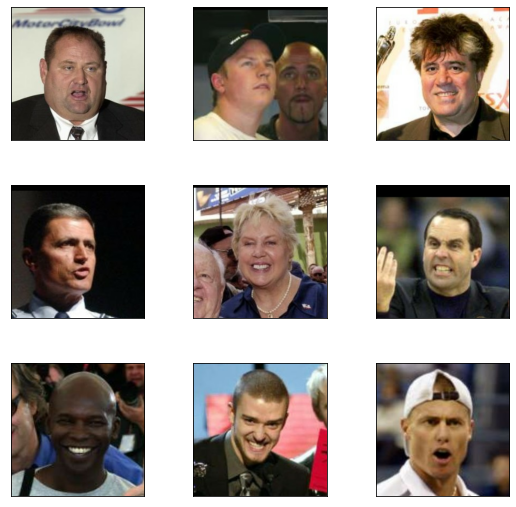

Dataset information:
{'train': <tfds.core.SplitInfo num_examples=13233>}
<PrefetchDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>


In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
IMG_SIZE = 28
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim]) 
tfds.show_examples(ds_info, ds_original)

print("Dataset information:")
print(ds_info.splits)
print(ds_original)


Resized dataset:


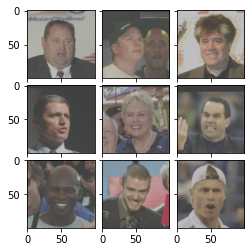

<BatchDataset shapes: (None, 100, 100, 3), types: tf.float32>


In [4]:
def preprocess(entry):
  img = tf.image.resize(entry['image'],[100,100])
  img = (img-127.5)/255
  return img

ds_small = ds_original.map(preprocess)

print ("Resized dataset:")
show_dataset_examples(ds_small)

train_dataset = ds_small.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 25, 256)))
    assert model.output_shape == (None, 25, 25, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100,100,3) 

    return model

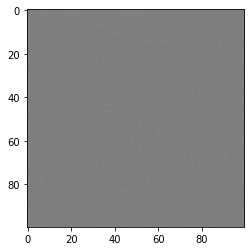

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 160000)            16000000  
_________________________________________________________________
batch_normalization (BatchNo (None, 160000)            640000    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 160000)            0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 25, 128)       0

In [6]:
def scale_and_show(img):
  plt.imshow((img+1)/2)

generator = make_generator_model()

noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

scale_and_show(generated_image[0])
plt.show()

print(generator.summary())

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3])) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) 

    return model

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)
print()
print (discriminator.summary())

tf.Tensor([[-0.00030339]], shape=(1, 1), dtype=float32)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_______________________________________________________________

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Make images:
      generated_images = generator(noise, training=True)

      #discriminator's output:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #loss:
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

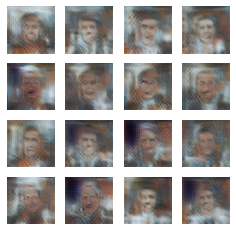

In [13]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
train(train_dataset, EPOCHS)

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

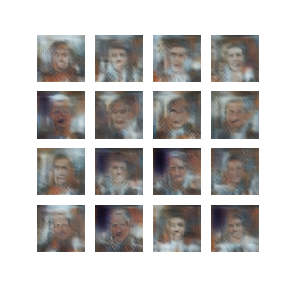

In [18]:
#Run this to display example images from a specific epoch of training.
display_image(100)

In [16]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>